Database connection established.


<ipython-input-10-78374dbccd43>:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
<ipython-input-10-78374dbccd43>:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Query executed successfully.


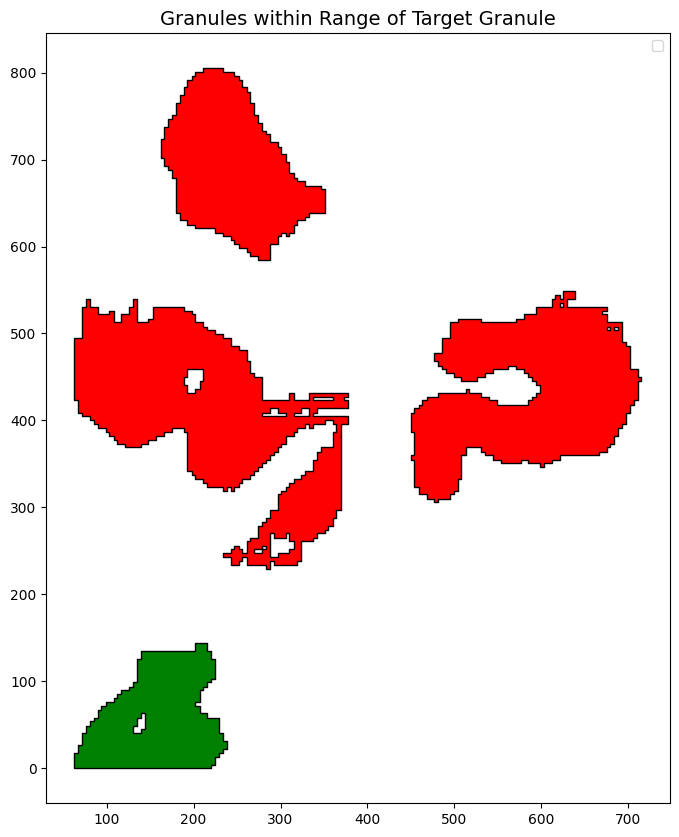

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb
import psycopg2

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Establish the database connection
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        database=database,
        user=user,
        password=password
    )
    print("Database connection established.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

# Define the query
query = """
WITH target_granule AS (
    SELECT id, ST_Centroid(shape) AS centroid, shape
    FROM granule_with_dot
    WHERE id = 1
)
SELECT g.id, g.tracked_id, g.shape, t.centroid
FROM granule_with_dot g, target_granule t
WHERE ST_DWithin(g.shape, t.centroid, 454.473684)
AND g.time = '2022-05-26 18:05:10';
"""

# Fetch the data
try:
    df = pd.read_sql(query, conn)
    print("Query executed successfully.")
except Exception as e:
    print(f"Error executing query: {e}")

# Close the connection
conn.close()

# Convert WKB to geometry
def parse_wkb(wkb_data):
    try:
        return wkb.loads(wkb_data, hex=True)
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

df['geometry'] = df['shape'].apply(parse_wkb)
df['centroid'] = df['centroid'].apply(parse_wkb)

# Drop rows where geometry parsing failed
df = df.dropna(subset=['geometry', 'centroid'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Separate target granule and neighbors
target_granule = gdf.iloc[0]  # The first row is the target
neighbors = gdf.iloc[1:]  # Remaining rows are neighbors

# Plot the granules
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all neighbors in red
neighbors.plot(ax=ax, color='red', edgecolor='black', alpha=1.0, label="Neighbors")

# Highlight the target granule in green
gpd.GeoDataFrame([target_granule], geometry='geometry').plot(
    ax=ax, color='green', edgecolor='black', alpha=1.0, label="Target Granule"
)

# Add labels and title
plt.title("Granules within Range of Target Granule", fontsize=14)
plt.legend()
plt.show()


Database connection established.


<ipython-input-6-becfb664e398>:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Query executed successfully.


<ipython-input-6-becfb664e398>:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Plot saved as /content/Range_query_singletype.pdf


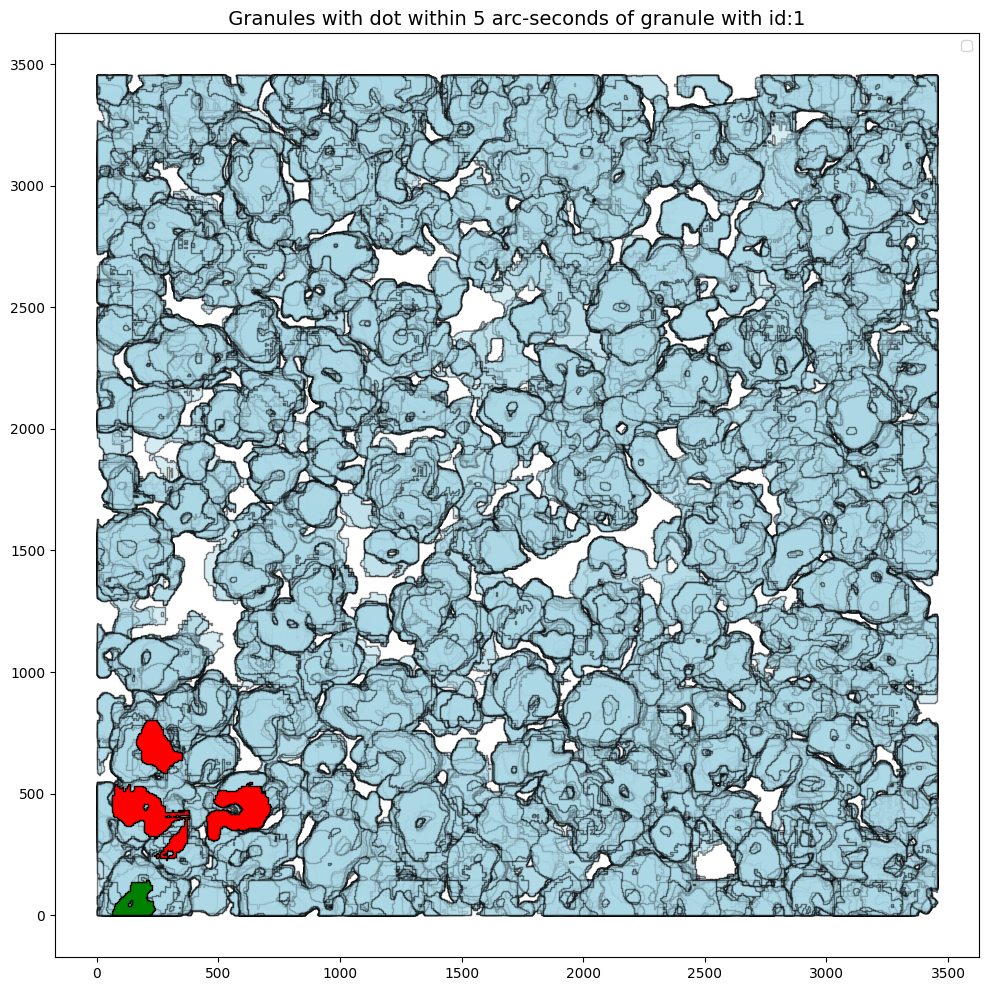

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb
import psycopg2

# Load all granules as the base layer
granules_df = pd.read_csv('/content/granule_with_dot_clean.csv')

# Convert WKB geometry in the CSV to shapely geometries
def parse_wkb(wkb_hex):
    try:
        return wkb.loads(bytes.fromhex(wkb_hex))
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

granules_df['geometry'] = granules_df['shape'].apply(parse_wkb)
granules_gdf = gpd.GeoDataFrame(granules_df, geometry='geometry')

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Establish the database connection
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        database=database,
        user=user,
        password=password
    )
    print("Database connection established.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

# Define the query to fetch the target and neighbors
query = """
WITH target_granule AS (
    SELECT id, ST_Centroid(shape) AS centroid, shape
    FROM granule_with_dot
    WHERE id = 1
)
SELECT g.id, g.tracked_id, g.shape, t.centroid
FROM granule_with_dot g, target_granule t
WHERE ST_DWithin(g.shape, t.centroid, 454.473684)
AND g.time = '2022-05-26 18:05:10';
"""

# Fetch query results
try:
    df = pd.read_sql(query, conn)
    print("Query executed successfully.")
except Exception as e:
    print(f"Error executing query: {e}")

# Close the database connection
conn.close()

# Parse WKB geometry in the query results
df['geometry'] = df['shape'].apply(parse_wkb)
df['centroid'] = df['centroid'].apply(parse_wkb)
df = df.dropna(subset=['geometry', 'centroid'])

# Convert to GeoDataFrame
query_gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Separate target granule and neighbors
target_granule = query_gdf.iloc[0]  # The first row is the target
neighbors_gdf = query_gdf.iloc[1:]  # Remaining rows are neighbors

# Plot all granules in the base dataset
fig, ax = plt.subplots(figsize=(12, 12))
granules_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label="All Granules")

# Highlight neighbors in red
neighbors_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=1.0, label="Neighbors")

# Highlight target granule in green
gpd.GeoDataFrame([target_granule], geometry='geometry').plot(
    ax=ax, color='green', edgecolor='black', alpha=1.0, label="Target Granule"
)

# Add title and legend
plt.title(" Granules with dot within 5 arc-seconds of granule with id:1 ", fontsize=14)
plt.legend()

# Save the plot as a PDF
output_file = "/content/Range_query_singletype.pdf"  # Replace with desired file path
plt.savefig(output_file, format="pdf", bbox_inches="tight")
print(f"Plot saved as {output_file}")


# Show the plot
plt.show()



WITH target_granule AS (
    SELECT id, ST_Centroid(shape) AS centroid
    FROM granule_with_dot
    WHERE id = 1
),
all_granules AS (
    SELECT id, tracked_id, shape, time FROM uniform_granule
    UNION ALL
    SELECT id, tracked_id, shape, time FROM granule_with_dot
    UNION ALL
    SELECT id, tracked_id, shape, time FROM granule_with_lane
    UNION ALL
    SELECT id, tracked_id, shape, time FROM complex_granule
)
SELECT g.id, g.tracked_id, g.shape
FROM all_granules g, target_granule t
WHERE ST_DWithin(g.shape, t.centroid, 454.473684)
AND time= '2022-05-26 18:05:10';


Database connection established.


<ipython-input-8-33d264245d03>:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
<ipython-input-8-33d264245d03>:94: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Query executed successfully.


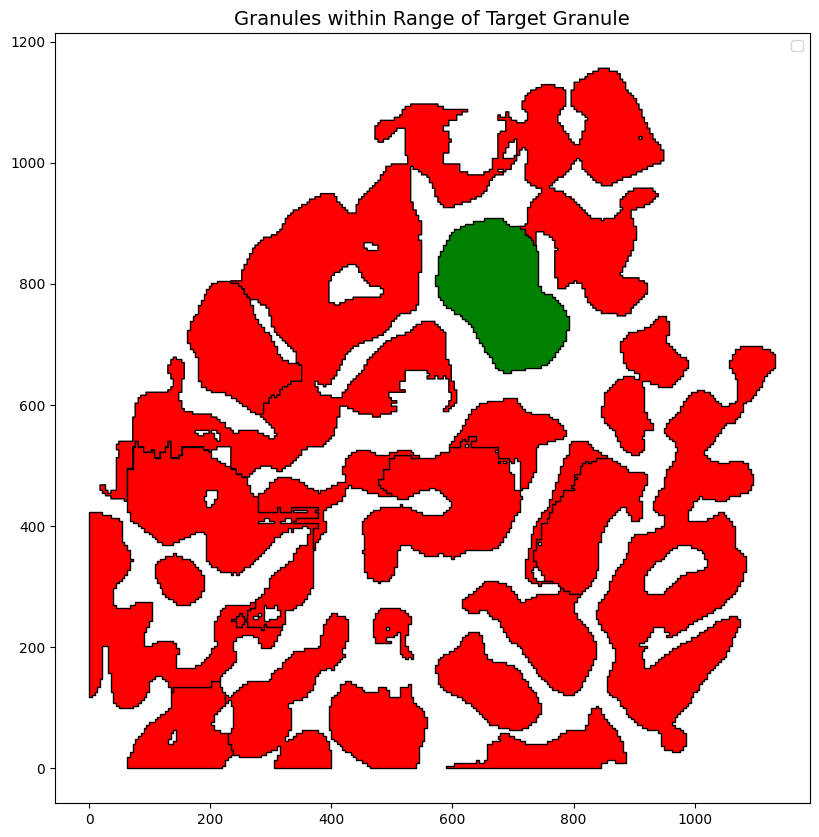

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb
import psycopg2

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Establish the database connection
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        database=database,
        user=user,
        password=password
    )
    print("Database connection established.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

# Define the query
query = """
WITH target_granule AS (
    SELECT id, ST_Centroid(shape) AS centroid
    FROM granule_with_dot
    WHERE id = 1
),
all_granules AS (
    SELECT id, tracked_id, shape, time FROM uniform_granule
    UNION ALL
    SELECT id, tracked_id, shape, time FROM granule_with_dot
    UNION ALL
    SELECT id, tracked_id, shape, time FROM granule_with_lane
    UNION ALL
    SELECT id, tracked_id, shape, time FROM complex_granule
)
SELECT g.id, g.tracked_id, g.shape, t.centroid
FROM all_granules g, target_granule t
WHERE ST_DWithin(g.shape, t.centroid, 454.473684)
AND g.time = '2022-05-26 18:05:10';

"""

# Fetch the data
try:
    df = pd.read_sql(query, conn)
    print("Query executed successfully.")
except Exception as e:
    print(f"Error executing query: {e}")

# Close the connection
conn.close()

# Convert WKB to geometry
def parse_wkb(wkb_data):
    try:
        return wkb.loads(wkb_data, hex=True)
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

df['geometry'] = df['shape'].apply(parse_wkb)
df['centroid'] = df['centroid'].apply(parse_wkb)

# Drop rows where geometry parsing failed
df = df.dropna(subset=['geometry', 'centroid'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Separate target granule and neighbors
target_granule = gdf.iloc[0]  # The first row is the target
neighbors = gdf.iloc[1:]  # Remaining rows are neighbors

# Plot the granules
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all neighbors in red
neighbors.plot(ax=ax, color='red', edgecolor='black', alpha=1.0, label="Neighbors")

# Highlight the target granule in green
gpd.GeoDataFrame([target_granule], geometry='geometry').plot(
    ax=ax, color='green', edgecolor='black', alpha=1.0, label="Target Granule"
)

# Add labels and title
plt.title("Granules within Range of Target Granule", fontsize=14)
plt.legend()
plt.show()


Database connection established.


<ipython-input-9-40ba96877e5c>:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_granules_df = pd.read_sql(all_granules_query, conn)


Fetched all granules successfully.


<ipython-input-9-40ba96877e5c>:68: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  range_df = pd.read_sql(range_query, conn)


Fetched range query results successfully.


<ipython-input-9-40ba96877e5c>:116: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Plot saved as granules_visualization.pdf.


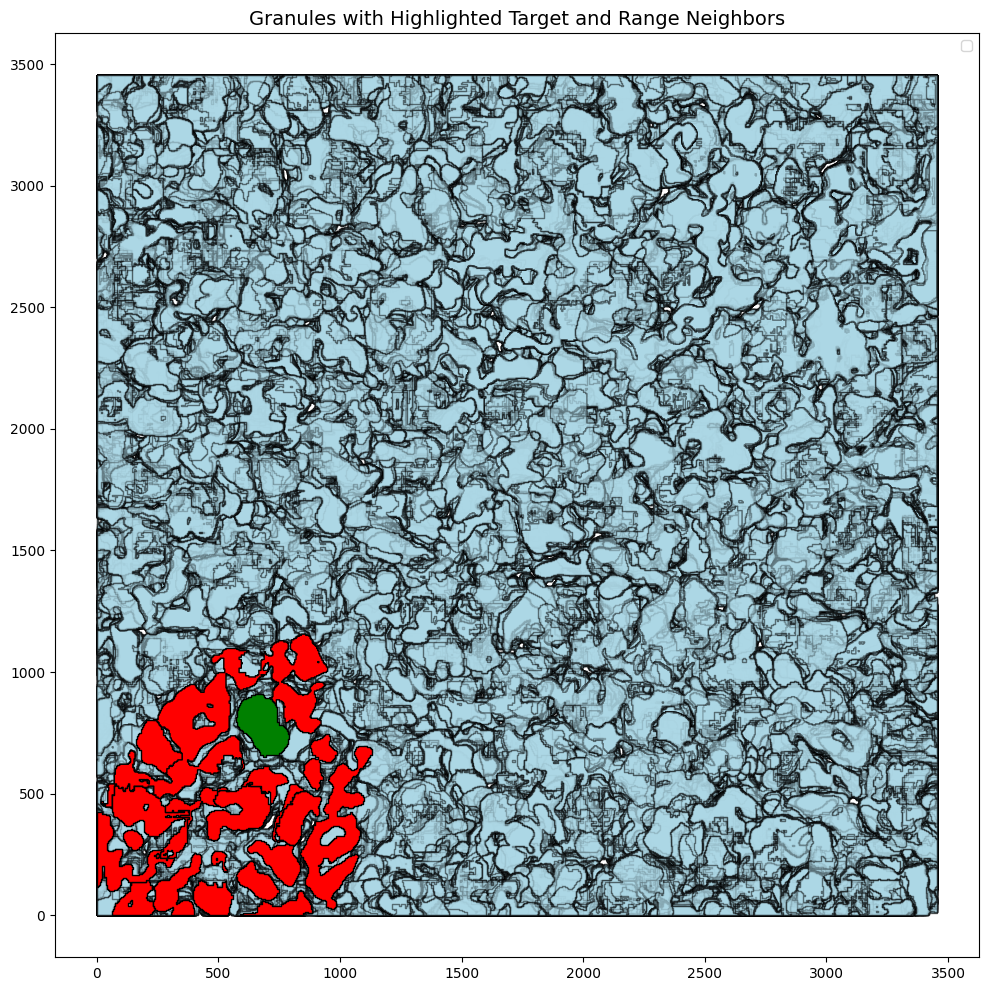

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb
import psycopg2

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Establish the database connection
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        database=database,
        user=user,
        password=password
    )
    print("Database connection established.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

# Query to fetch all granules
all_granules_query = """
SELECT id, tracked_id, shape, time FROM uniform_granule
UNION ALL
SELECT id, tracked_id, shape, time FROM granule_with_dot
UNION ALL
SELECT id, tracked_id, shape, time FROM granule_with_lane
UNION ALL
SELECT id, tracked_id, shape, time FROM complex_granule;
"""

# Query to fetch granules within range
range_query = """
WITH target_granule AS (
    SELECT id, ST_Centroid(shape) AS centroid
    FROM granule_with_dot
    WHERE id = 1
)
SELECT g.id, g.tracked_id, g.shape
FROM (
    SELECT id, tracked_id, shape, time FROM uniform_granule
    UNION ALL
    SELECT id, tracked_id, shape, time FROM granule_with_dot
    UNION ALL
    SELECT id, tracked_id, shape, time FROM granule_with_lane
    UNION ALL
    SELECT id, tracked_id, shape, time FROM complex_granule
) g, target_granule t
WHERE ST_DWithin(g.shape, t.centroid, 454.473684)
AND g.time = '2022-05-26 18:05:10';
"""

# Fetch all granules data
try:
    all_granules_df = pd.read_sql(all_granules_query, conn)
    print("Fetched all granules successfully.")
except Exception as e:
    print(f"Error fetching all granules: {e}")

# Fetch granules within range
try:
    range_df = pd.read_sql(range_query, conn)
    print("Fetched range query results successfully.")
except Exception as e:
    print(f"Error fetching range query results: {e}")

# Close the database connection
conn.close()

# Convert WKB to geometry
def parse_wkb(wkb_data):
    try:
        return wkb.loads(wkb_data, hex=True)
    except Exception as e:
        print(f"Error parsing WKB: {e}")
        return None

# Parse geometries
all_granules_df['geometry'] = all_granules_df['shape'].apply(parse_wkb)
range_df['geometry'] = range_df['shape'].apply(parse_wkb)

# Drop rows where geometry parsing failed
all_granules_df = all_granules_df.dropna(subset=['geometry'])
range_df = range_df.dropna(subset=['geometry'])

# Convert to GeoDataFrames
all_granules_gdf = gpd.GeoDataFrame(all_granules_df, geometry='geometry')
range_gdf = gpd.GeoDataFrame(range_df, geometry='geometry')

# Extract the target granule and neighbors from range_gdf
target_granule = range_gdf.iloc[0]  # Assume the first row is the target
neighbors_gdf = range_gdf.iloc[1:]  # Remaining rows are neighbors

# Plot all granules
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all granules in light blue
all_granules_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label="All Granules")

# Highlight neighbors in red
neighbors_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=1.0, label="Granules in Range")

# Highlight the target granule in green
gpd.GeoDataFrame([target_granule], geometry='geometry').plot(
    ax=ax, color='green', edgecolor='black', alpha=1.0, label="Target Granule"
)

# Add title and legend
plt.title("Granules with Highlighted Target and Range Neighbors", fontsize=14)
plt.legend()

# Save plot as PDF
plt.savefig("granules_visualization.pdf")
print("Plot saved as granules_visualization.pdf.")

# Show plot
plt.show()
